# **Machine Learning Models and Evaluation**

### **Classification Model**


Now that the data has been pre-processed to my liking (so far) we can begin the fun process of finding a machine learning algorithm that will best predict the winner of a game!

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
import pickle

os.chdir('C:\\Users\\Mike Delevan\\Documents\\gl2010_18') #Copy of data for notebook usage

Predicting the winner of a game is a classification problem, therefore Logistic Regression will need to be used to determine the Win/Loss Outcome.

## **Training/Testing on Unprocessed Data**
To illustrate the difference that data pre-processing can make, we will first train and test a logistic regression model using all of the unprocessed data (46,000 rows x 75 columns). Let's look at the correlation matrix for a large amount of the original variables in the dataset. Many variables were removed before the graph was made to make sure that the correlation matrix is still readable and understandable.

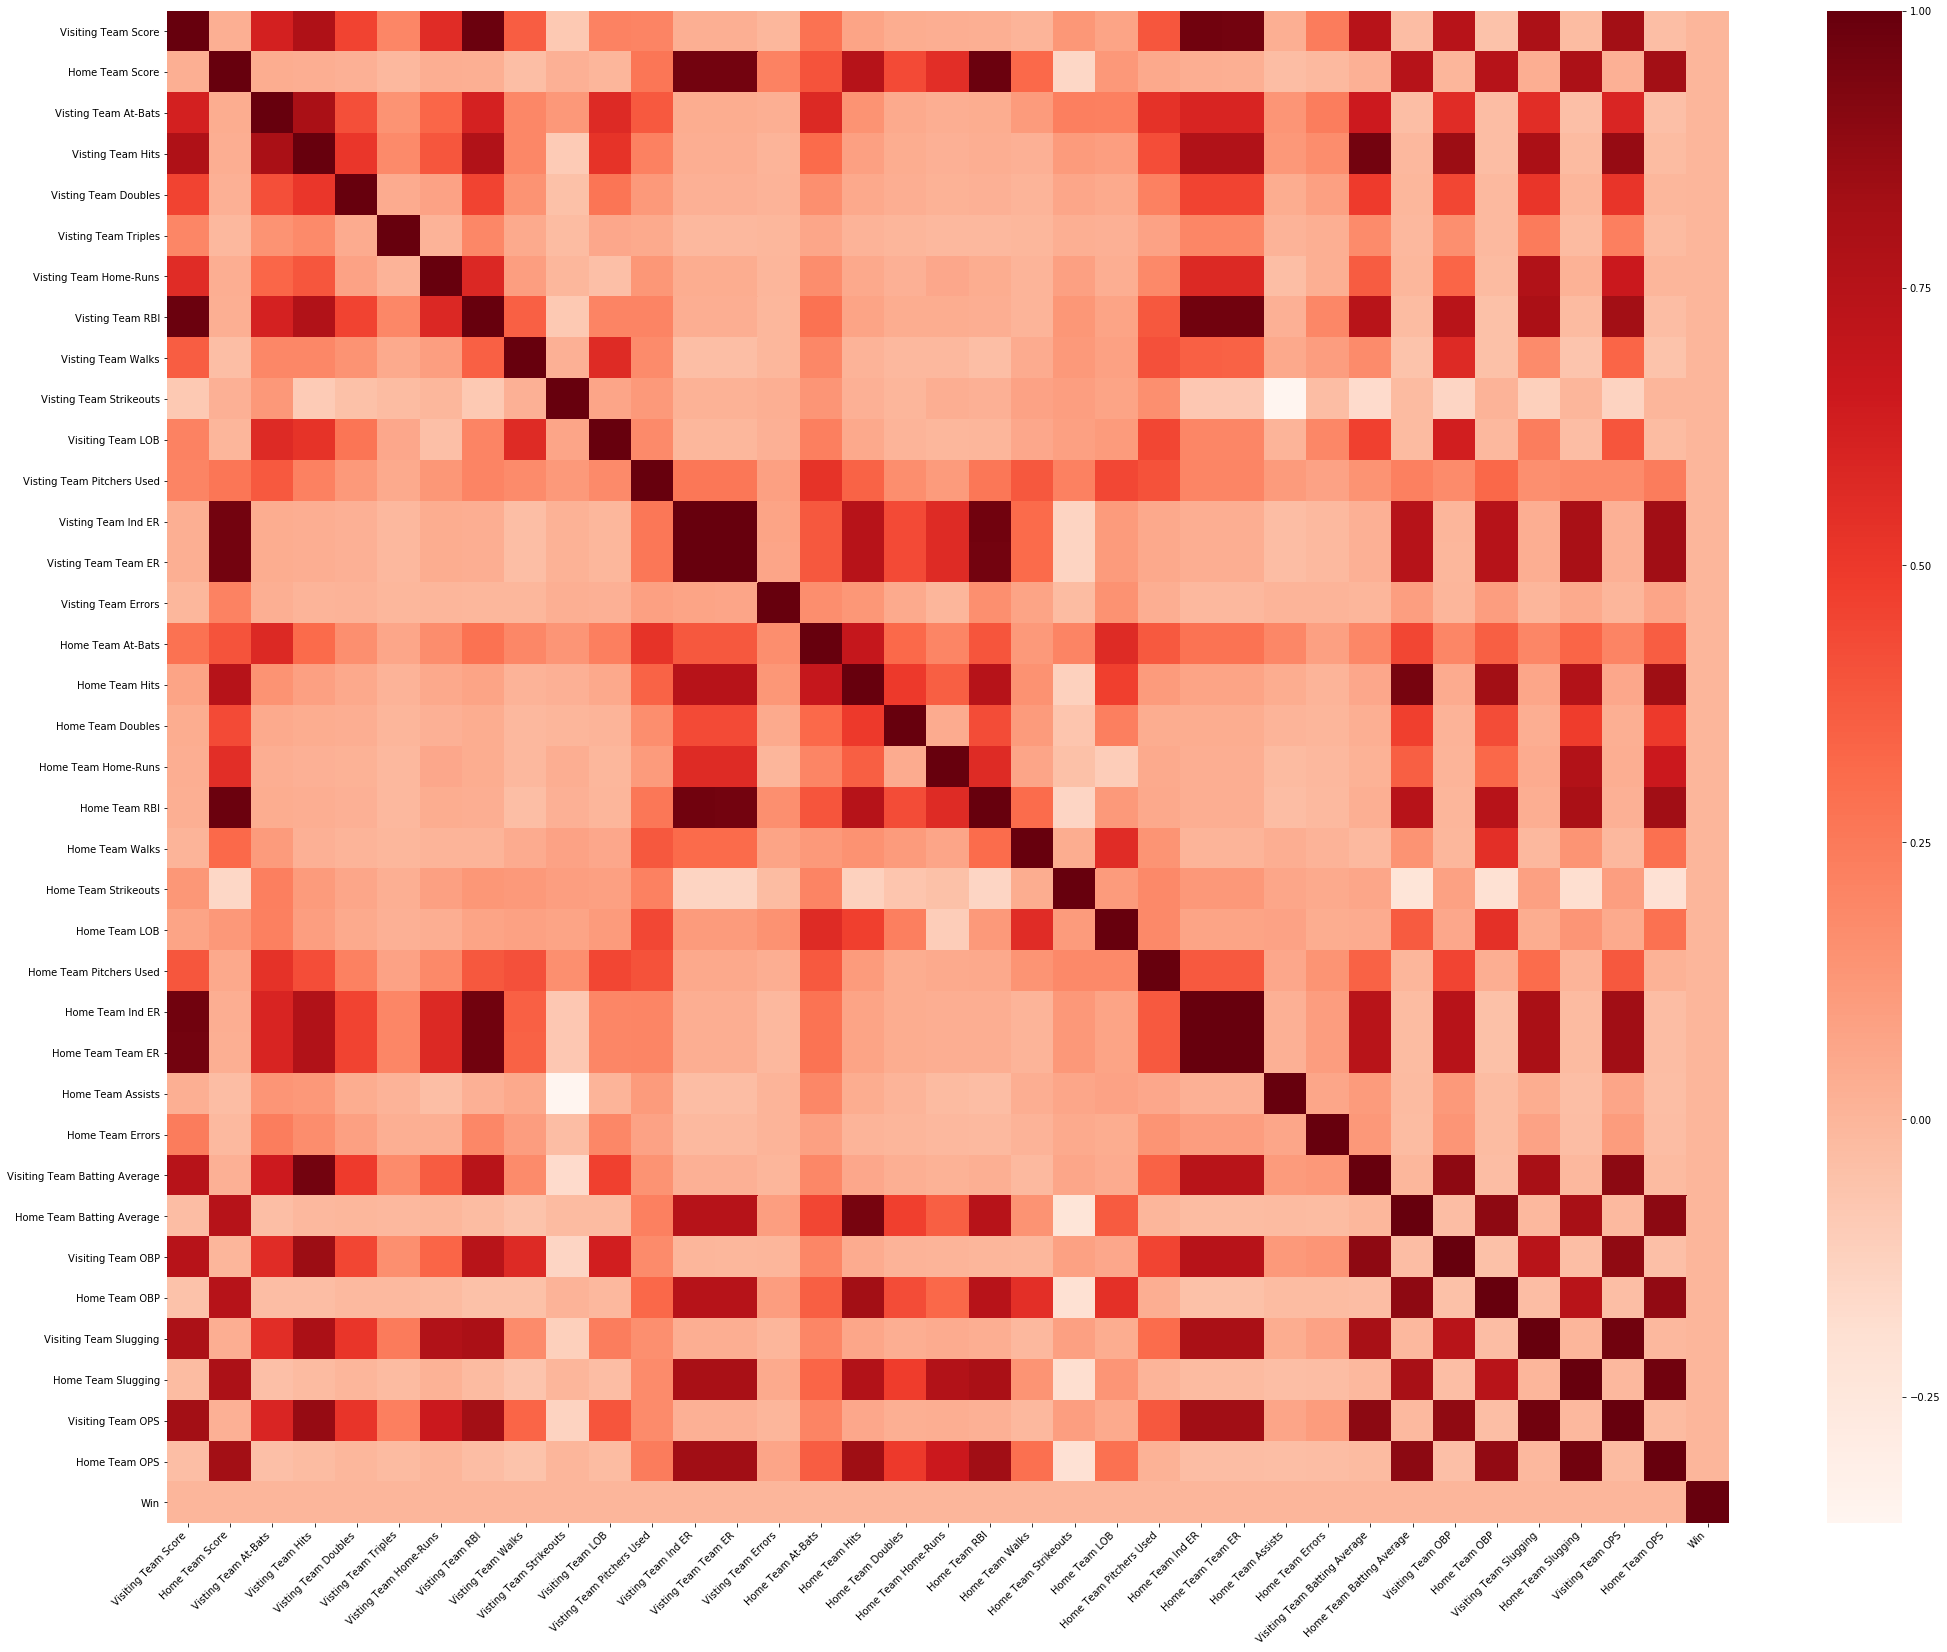

In [3]:
data = pd.read_csv('combinedDataBad.csv')

data.drop(['Visting Team','Date', 'League', 'Home Team', 'League.1', 'Park ID'], axis=1, inplace=True)
data.drop(['Winning Pitcher ID', 'Visting Team Stolen Bases', 'Saving Pitcher ID','Home Team Stolen Bases', 'Visting Team Caught Stealing',
            'Home Team Caught Stealing', 'Visting Team G Double Play', 'Home Team G Double Play',
            'Losing Pitcher ID', 'Saving Pitcher ID', 'Visiting Starter Pitcher ID', 'Home Starter Pitcher ID',
            'Visting Team Awarded First on Interference', 'Home Team Awarded First on Interference',
            'Visting Team Balks', 'Home Team Balks', 'Visting Team Put-outs', 'Home Team Put-outs',
            'Visting Team Assists', 'Visting Team Passed Balls', 'Home Team Passed Balls',
            'Visting Team Double Plays','Attendance', 'Home Team Double Plays',
            'Home Team Triple Plays', 'Visting Team Triple Plays', 'Home Team Triples',
            'Visiting Team Sac Hits', 'Home Team Int Walks', 'Visting Team Int Walks',
            'Home Team Sac Hits', 'Length of Game in Outs', 'Visting Team Sac Flys', 'Home Team Sac Flys',
            'Home Team Wild Pitches', 'Home Team HBP', 'Visting Team HBP', 'Visting Team Wild Pitches',
            'Visiting Team Game Number', 'Home Team Game Number', 'wonPrev'], axis=1, inplace=True)

try:
    data.drop(['Unnamed: 0'], axis=1, inplace=True)
    data.drop(['Unnamed: 75'], axis=1, inplace=True)

except KeyError:
    print("Column is not in the file!!!")

data.dropna(axis=0)

plt.subplots(figsize=(35,35))
cor = data.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.gcf().subplots_adjust(top=.95,bottom=0.35)
plt.xticks(rotation=45,ha='right')
fig = plt.gcf()
plt.show()

Because there are so many vairables in the dataframe, there ends up being no variables that really correlate with a win. This is obviously not good and thus means that we need to do more data preprocessing which we have done. Let's show how well this unprocessed data will perform with a simple machine learning algorithm:

In [4]:
logmodel = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(data.drop('Win', axis=1),
                                                        data['Win'], test_size=0.20,
                                                        random_state=101)

Here we are modifying the data into a 80/20 train/test split along with their actual labels also split. Here, scikit-learn comes with a pre-packaged method that splits the data into a specified size which is really handy. First, we drop the Win column from the dataframe, which will become X_train and X_test, as that is the label we're predicting and supply that to train_test_split. We then feed those Win values back into train_test_split to get y_train and y_test so that we can measure the accuracy of our model. We supply our test set size to get a good split like 80/20 or 70/30. A seed is also set so that the results can be consistent across developers. Now that this is out of the way, let's train on bad data!

In [5]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

logmodel.fit(X_train, y_train)


logistic_reg_score_train = logmodel.score(X_train, y_train)
print("Percentage correct on training set = ", 100. * logistic_reg_score_train, "%")

c:\users\mike delevan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Percentage correct on training set =  50.424807620791256 %


So without any sort of preprocessing our model can get 50.4% correct on the training set which isn't good but isn't bad either, kind of like the Red Sox. Let's see how it does on the test set, AKA data it's never seen before:

              precision    recall  f1-score   support

           0       0.48      0.44      0.46      4386
           1       0.48      0.53      0.51      4354

    accuracy                           0.48      8740
   macro avg       0.48      0.48      0.48      8740
weighted avg       0.48      0.48      0.48      8740

[[1917 2469]
 [2049 2305]]


[Text(0, 0.5, 'Loss'), Text(0, 1.5, 'Win')]

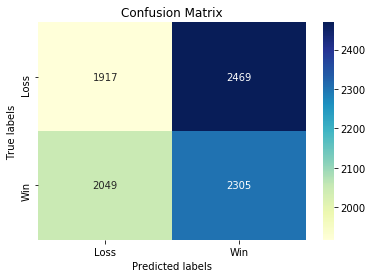

In [7]:
predictions = logmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

#plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(pd.DataFrame(conf_matrix),annot=True, cmap="YlGnBu", fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Loss', 'Win'])
ax.yaxis.set_ticklabels(['Loss', 'Win'])

In [8]:
logistic_reg_score_test = logmodel.score(X_test, y_test)
print("Percentage correct on training set = ", 100. * logistic_reg_score_test, "%")

Percentage correct on training set =  48.306636155606405 %


So our model does slightly worse on the test data getting around 48% correct on the test set. Let's do more in depth model training and testing on the processed data and see what our outcome is!

## **Training/Testing on Processed Data**

First, we will get the feature importances of every variables in the processed dataset to identify any variables that are not important to the task of classification. Doing this before training will allow us to remove any of the identified variables before we move on.

In [36]:
data = pd.read_csv('combinedData.csv')

data.drop(['teamAbbr','League', 'Unnamed: 0'], axis=1, inplace=True)

print("Number of null values:", data.isnull().sum())

Number of null values: Score             0
isHomeTeam        0
atBats            0
Hits              0
Doubles           0
Triples           0
homeRuns          0
RBI               0
Walks             0
Strikeouts        0
LOB               0
pitchersUsed      0
indER             0
teamER            0
Errors            0
battingAverage    0
OBP               0
Slugging          0
OPS               0
Win               0
dtype: int64


Thankfully, there are no columns with missing values in the dataset, therefore we will not need to do any imputations. Let's now do the subset selection using RFE:

In [39]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

X_train, X_test, y_train, y_test = train_test_split(data.drop('Win', axis=1),
                                                        data['Win'], test_size=0.20,
                                                        random_state=101)
log_model = LogisticRegression()
rfe = RFE(log_model, 18)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

header_names = X_train.columns.values.tolist()
for x in range(19):
    if(fit.support_[x] == True):
        print(header_names[x])


c:\users\mike delevan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\mike delevan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Num Features: 18
Selected Features: [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
Feature Ranking: [1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Score
isHomeTeam
atBats
Hits
Triples
homeRuns
RBI
Walks
Strikeouts
LOB
pitchersUsed
indER
teamER
Errors
battingAverage
OBP
Slugging
OPS


The results from RFE give us a list of features that are most important in the data when it comes to predicting a win. In this case the variable that got removed in this instance is doubles while all of the other variables are equally as important. We will remove the doubles variable from the dataset moving forward with testing and training. Let's remove this variable from the dataset and plot the correlation matrix for the dataset without doubles.

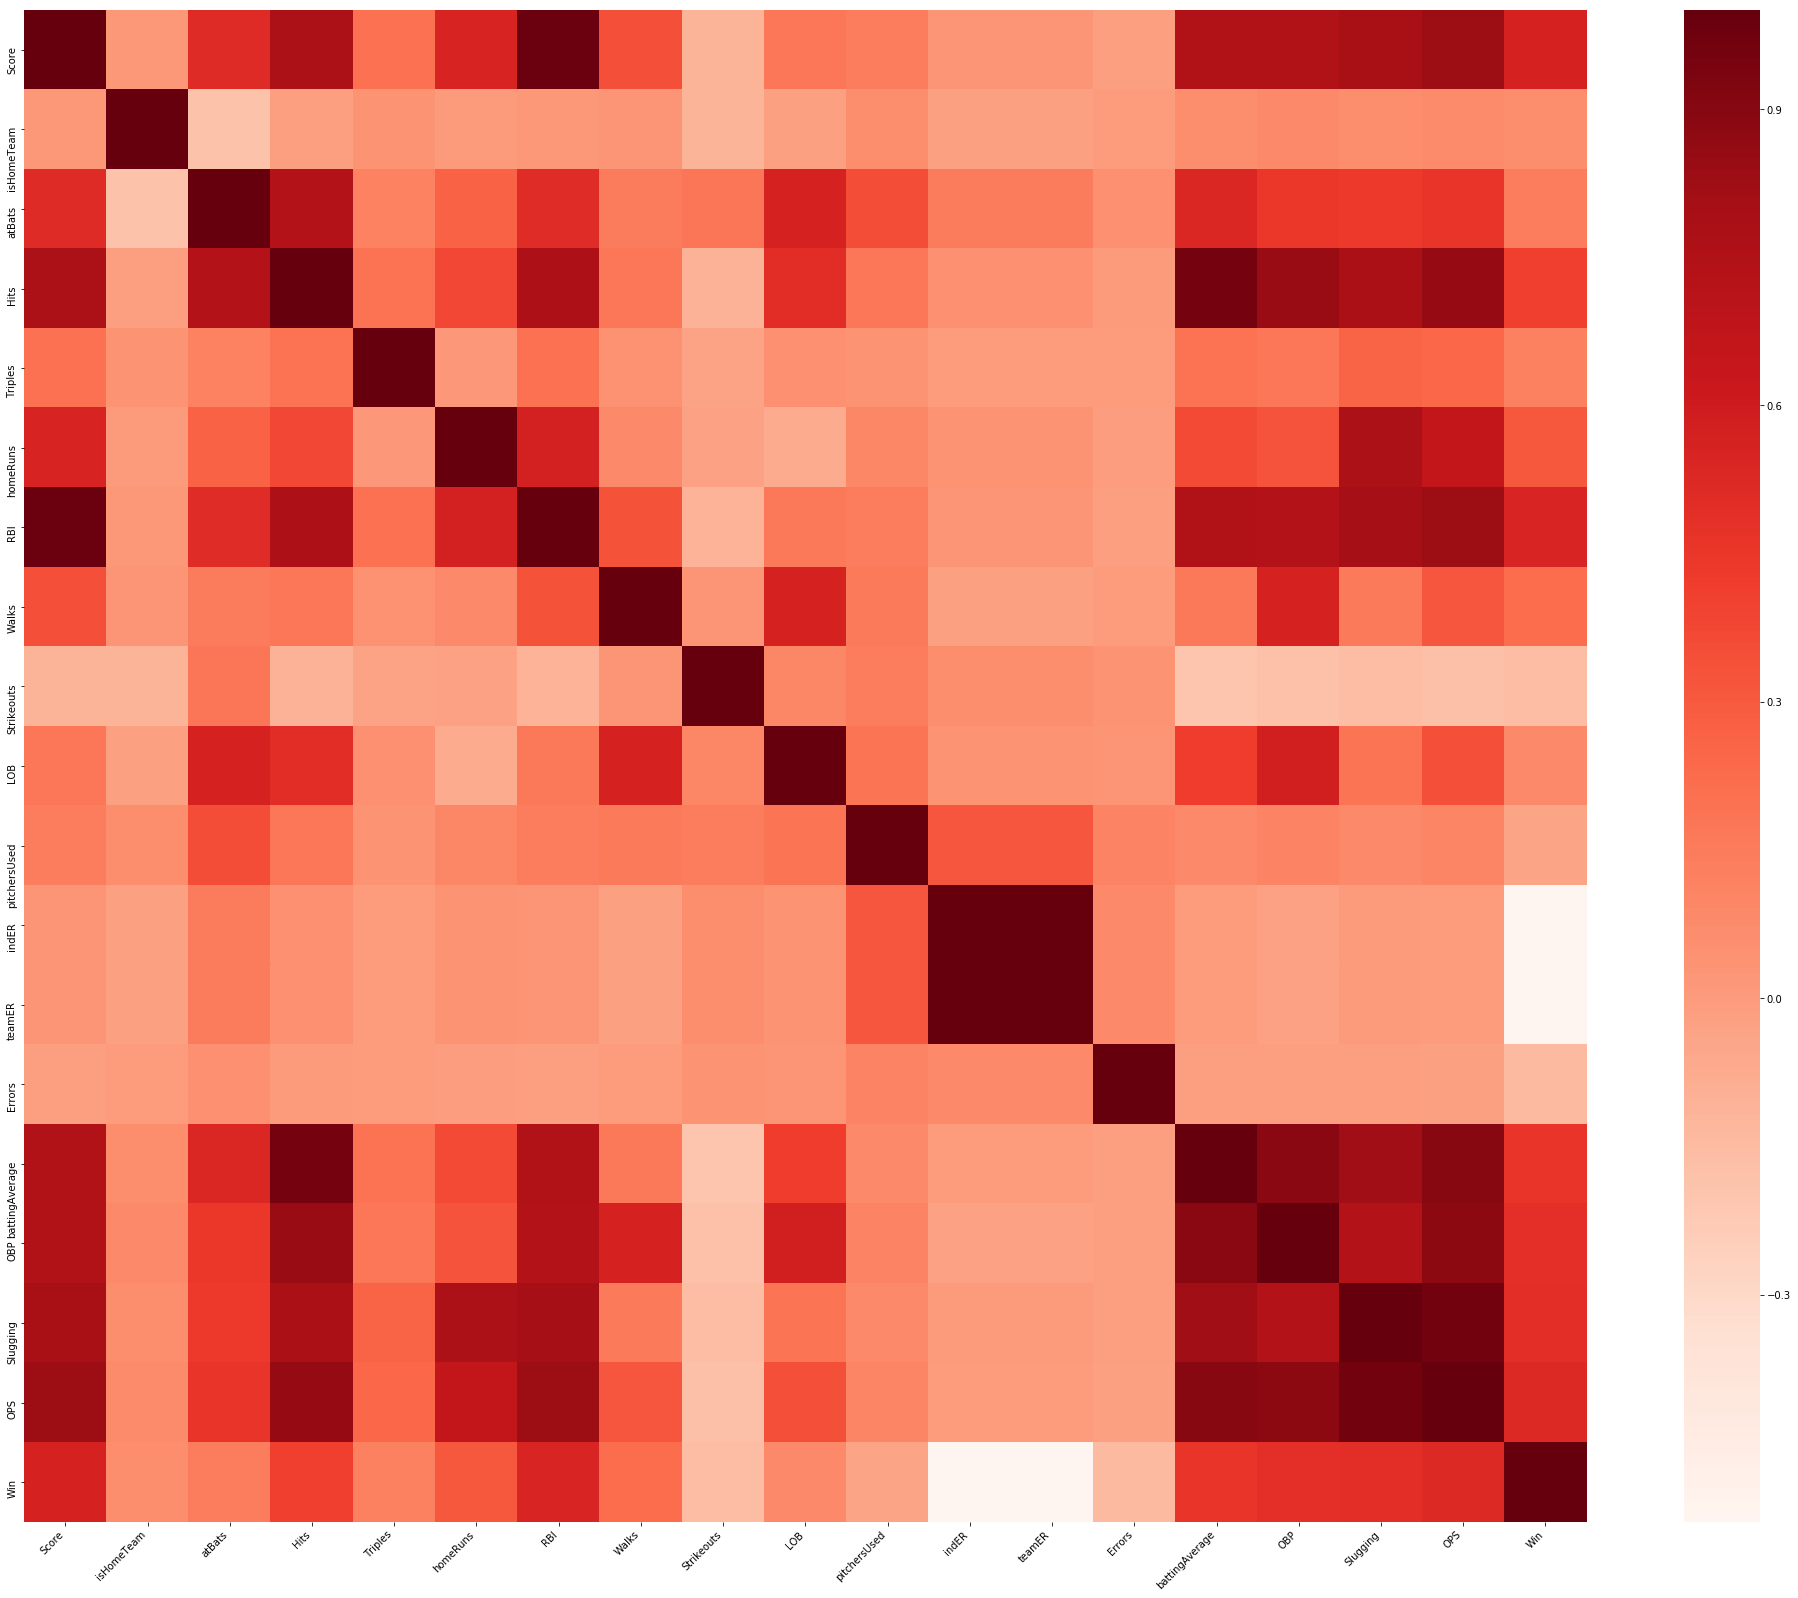

In [40]:
data.drop(['Doubles'], axis=1, inplace=True)
plt.subplots(figsize=(35,35))
cor = data.corr()
sns.heatmap(cor, cmap=plt.cm.Reds)
plt.gcf().subplots_adjust(top=.95,bottom=0.35)
plt.xticks(rotation=45,ha='right')
fig = plt.gcf()
plt.show()

Compared to the other correlation matrix, this is much better! As you can see there are a lot more variables that are correlated with a win such as OBP, OPS, and Score. Let's see how it does in the machine learning aspect:

In [48]:
logmodel = LogisticRegression()
X_train.drop(['Doubles'], axis=1, inplace=True)
X_test.drop(['Doubles'], axis=1, inplace=True)

KeyError: "['Doubles'] not found in axis"

In [49]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

logmodel.fit(X_train, y_train)


logistic_reg_score_train = logmodel.score(X_train, y_train)
print("Percentage correct on training set = ", 100. * logistic_reg_score_train, "%")

c:\users\mike delevan\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Percentage correct on training set =  98.77423737186612 %


So using the processed data got us a 98.7% correct test accuracy which is really good. However the accuracy we want to see is the test data. Next we will be using 10-fold cross validation to estimate the test accuracy. This is helpful when you don't have enough data to do a train and test set split. However, in this case there is more than enough data to do the split so we will get the cross-validated test accuracy and then actaully compute it to see if they agree with one another. We will be using the already split training data in this case to estimate the test accuracy, and then using the actual test set to validate our findings

In [54]:
from sklearn.model_selection import RepeatedKFold

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

scores = []
cv_log_model = LogisticRegression()
cv = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 42)
for train_index, test_index in cv.split(X_train):

    X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_train.iloc[test_index]
    cv_log_model.fit(X_train_cv, y_train_cv)
    scores.append(cv_log_model.score(X_test_cv, y_test_cv))
    
print(np.mean(scores))

0.987643547095591


Our 10-Fold Repreated Cross Validation estimated our test error to be around **98.7%** which is an absolutely incredible score. Let's see how the model actually performs on the test data that has been held out this entire time.

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4013
           1       0.98      0.99      0.99      4085

    accuracy                           0.99      8098
   macro avg       0.99      0.99      0.99      8098
weighted avg       0.99      0.99      0.99      8098

[[3937   76]
 [  33 4052]]


[Text(0, 0.5, 'Loss'), Text(0, 1.5, 'Win')]

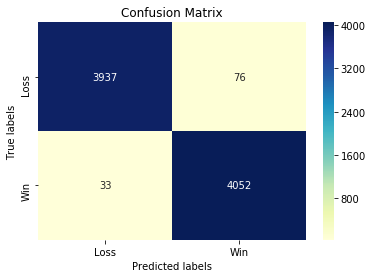

In [55]:
predictions = logmodel.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

#plt.figure(figsize=(10,10))
ax = plt.subplot()
sns.heatmap(pd.DataFrame(conf_matrix),annot=True, cmap="YlGnBu", fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Loss', 'Win'])
ax.yaxis.set_ticklabels(['Loss', 'Win'])

In [56]:
logistic_reg_score_test = logmodel.score(X_test, y_test)
print("Percentage correct on training set = ", 100. * logistic_reg_score_test, "%")

Percentage correct on training set =  98.65398863917017 %


I see this as an absolute win. Using just the pre-processed and feature engineered data increased our model's accuracy from **48%** to **98.6%** which is an incredible imporvement. This showcases the power that initial data analysis and pre-processing can have on the results of machine learning models. The actual test accuracy in this case validates our test accuracy estimate calculated by 10-Fold Repeated Cross Validation which was **98.7%**. Although it is just a tad bit lower it is still an amazing result which tells us that predicting the winners of baseball games can be well estimated by using logistic regression. Even though we already evaluated our model's predictive abilities we should probably plot the ROC curve for the logistic regression model to see if our .5 threshold value is the most optimal for the task at hand:

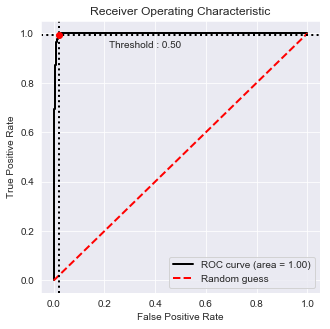

In [57]:
y_pred = logmodel.predict_proba(X_test)[:,1]
from plot_metric.functions import BinaryClassification

bc = BinaryClassification(y_test, y_pred, labels=["Win", "Loss"])

plt.figure(figsize=(5, 5))
bc.plot_roc_curve()
plt.show()

The black line in this graph indicates the ROC curve generated by our trained and tested logistic regression model and the red line indicates a ROC curve generated by a logistic regression model that, in a sense, just guesses (like our model that used unprocessed data). FOr this graph we want to see that as the true positive rate gets close to 1 that the false positive rate gets as close to 0 as possible. In this case the ROC does just this and almost perfectly fits the description of what we want in an ROC curve. From this graph we can determine that the .5 threshold value for the logistic regression model is optimal and will not need to be changed.